In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.rcdefaults()

In [3]:
DATA_FOLDER = "../Data/"

imdb_basics_raw = pd.read_csv(
    DATA_FOLDER + "IMDb/title.basics.tsv.gz",
    sep="\t",
    compression="gzip",
)
imdb_ratings_raw = pd.read_csv(
    DATA_FOLDER + "IMDb/title.ratings.tsv.gz",
    sep="\t",
    compression="gzip",
)
movies_raw = pd.read_csv(DATA_FOLDER + "MovieSummaries/movie.metadata.tsv", sep="\t")

In [4]:
movies_raw.columns = [
    "wikiID",
    "fbID",
    "name",
    "releaseDate",
    "boxOffice",
    "runtime",
    "languages",
    "countries",
    "genres",
]

imdb_basics_raw.rename(
    columns={
        "primaryTitle": "name",
        "startYear": "releaseYear",
        "runtimeMinutes": "runtime",
    },
    inplace=True
)

In [5]:
movies = movies_raw.copy()
imdb_basics = imdb_basics_raw.copy()
imdb_ratings = imdb_ratings_raw.copy()

In [6]:
# Merge both imdb datasets
imdb = pd.merge(imdb_basics, imdb_ratings, on='tconst', how='left')

In [7]:
imdb["releaseYear"] = pd.to_numeric(imdb["releaseYear"], errors="coerce")

movies["releaseMonth"] = pd.to_datetime(
    movies["releaseDate"],
    errors="coerce",
).dt.month

movies["releaseYear"] = pd.to_datetime(
    movies["releaseDate"], errors="coerce", format="mixed"
).dt.year

movies.drop(columns=["releaseDate"], inplace=True)

In [8]:
movies.drop_duplicates(subset=["name", "releaseMonth", "releaseYear"], inplace=True)
imdb.drop_duplicates(subset=["name", "releaseYear"], inplace=True)

In [9]:
imdb.runtime = pd.to_numeric(imdb.runtime, errors="coerce")

In [10]:
movies_imdb = pd.merge(movies, imdb, how="left", on=["name", "releaseYear", "runtime"], suffixes=["Cmu", "Imdb"])

In [11]:
# Function to extract genres from the string representation of dictionary-like data
def parse_dict(s):
    try:
        genres_dict = eval(s.replace('null', 'None'))
        values = list(genres_dict.values())
        if len(values) == 0:
            return np.nan
        else:
            return values
    except:
        return np.nan


movies_imdb['languages'] = movies_imdb['languages'].apply(parse_dict)
movies_imdb['countries'] = movies_imdb['countries'].apply(parse_dict)
movies_imdb['genresCmu'] = movies_imdb['genresCmu'].apply(parse_dict)

movies_imdb['genresImdb'] = movies_imdb['genresImdb'].apply(
    lambda x: x.split(',') if not isinstance(x, float) else np.nan)

In [12]:
print(movies.shape)
print(movies_imdb.shape)
movies_imdb.head(10)

(81630, 10)
(81630, 18)


,wikiID,fbID,name,boxOffice,runtime,languages,countries,genresCmu,releaseMonth,releaseYear,tconst,titleType,originalTitle,isAdult,endYear,genresImdb,averageRating,numVotes
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2.0,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,1988.0,tt0094806,movie,Brun bitter,0,\N,"[Crime, Drama]",5.6,40.0
2,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",NaN,1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German Language],[Germany],[Drama],NaN,1983.0,tt0083949,movie,Die flambierte Frau,0,\N,[Drama],6.0,621.0
4,13696889,/m/03cfc81,The Gangsters,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",5.0,1913.0,tt0002894,short,The Gangsters,0,\N,"[Comedy, Short]",6.8,16.0
5,18998739,/m/04jcqvw,The Sorcerer's Apprentice,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",NaN,2002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",8.0,1938.0,tt0029852,movie,Alexander's Ragtime Band,0,\N,"[Drama, Music, Musical]",6.8,2264.0
7,9997961,/m/06_y2j7,Contigo y aquí,NaN,NaN,[Spanish Language],[Argentina],"[Musical, Drama, Comedy]",NaN,1974.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2345652,/m/075f66,City of the Dead,NaN,76.0,[English Language],[United Kingdom],"[Horror, Supernatural]",NaN,1960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,175026,/m/017n1p,Sarah and Son,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]",NaN,1930.0,tt0021335,movie,Sarah and Son,0,\N,"[Drama, Romance]",5.4,298.0


In [13]:
characters_raw = pd.read_csv(DATA_FOLDER + "MovieSummaries/character.metadata.tsv", sep='\t')
oscars_raw = pd.read_csv(DATA_FOLDER + "Oscars/the_oscar_award.csv", sep=',')

In [14]:
characters_raw.columns = [
    "wikiID",
    "fbID",
    "releaseDate",
    "characterName",
    "DOB",
    "gender",
    "height",
    "ethnicity",
    "name",
    "ageAtMovieRelease",
    "fbCharacterMap",
    "fbCharacterID",
    "fbActorID",
]

In [15]:
oscars_raw = oscars_raw.drop(columns=["ceremony", "year_ceremony", "film"])
oscars_raw.rename(columns={"year_film": "releaseYear", "category": "oscarCategory", "winner": "oscarWinner"},
                  inplace=True)

In [16]:
characters = characters_raw.copy()
oscars = oscars_raw.copy()

In [17]:
characters["releaseYear"] = pd.to_datetime(
    characters["releaseDate"],
    errors="coerce",
    yearfirst=True,
).dt.year
characters["releaseMonth"] = pd.to_datetime(
    characters["releaseDate"],
    errors="coerce",
    yearfirst=True,
).dt.month
characters.drop(columns=["releaseDate"], inplace=True)

In [18]:
characters_oscars = pd.merge(characters, oscars, on=["name", 'releaseYear'], how="left")
print(characters_oscars.shape)
characters_oscars.head(10)

(450713, 16)


,wikiID,fbID,characterName,DOB,gender,height,ethnicity,name,ageAtMovieRelease,fbCharacterMap,fbCharacterID,fbActorID,releaseYear,releaseMonth,oscarCategory,oscarWinner
0,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,8.0,NaN,NaN
1,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0,8.0,NaN,NaN
2,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0,8.0,NaN,NaN
3,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0,8.0,NaN,NaN
4,975900,/m/03vyhn,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,2001.0,8.0,NaN,NaN
5,975900,/m/03vyhn,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m,2001.0,8.0,NaN,NaN
6,975900,/m/03vyhn,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7,2001.0,8.0,NaN,NaN
7,975900,/m/03vyhn,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0,2001.0,8.0,NaN,NaN
8,975900,/m/03vyhn,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy,2001.0,8.0,NaN,NaN
9,975900,/m/03vyhn,Dos,NaN,M,NaN,NaN,Lobo Sebastian,NaN,/m/0bgchsc,/m/0bgchsg,/m/0bgchsp,2001.0,8.0,NaN,NaN


In [19]:
budget_raw = pd.read_csv(
    DATA_FOLDER + "Budget/movies_metadata.csv.zip",
    compression="zip",
)

In [20]:
budget = budget_raw[
    [
        "budget",
        "imdb_id",
        "original_title",
        "popularity",
        "revenue",
        "vote_average",
        "vote_count",
        "release_date",
    ]
].copy()

In [21]:
budget.columns = [
    "budget",
    "tconst",
    "name",
    "popularity",
    "revenue",
    "voteAverage",
    "voteCount",
    "releaseDate",
]

In [22]:
#budget["releaseMonth"] = pd.to_datetime(budget["releaseDate"], errors="coerce").dt.month
#budget["releaseYear"] = pd.to_datetime(budget["releaseDate"], errors="coerce").dt.year
#budget.drop_duplicates(subset=["name", "releaseMonth", "releaseYear"], inplace=True)
budget.drop(columns=["releaseDate", "name", "revenue", "voteAverage", "voteCount"], inplace=True)

In [23]:
budget["budget"] = pd.to_numeric(budget["budget"], errors="coerce")

In [24]:
budget.head()

,budget,tconst,popularity
0,30000000.0,tt0114709,21.946943
1,65000000.0,tt0113497,17.015539
2,0.0,tt0113228,11.7129
3,16000000.0,tt0114885,3.859495
4,0.0,tt0113041,8.387519


In [25]:
# remove tconst nan entries to avoid issues when merging
print(budget.tconst.isnull().sum())
budget.dropna(subset=['tconst'], inplace=True)
print(budget.shape)

17
(45449, 3)


In [26]:
# remove duplicate tconst entries
print(budget.tconst.duplicated().sum())
budget.drop_duplicates(subset='tconst', inplace=True)
print(budget.shape)

32
(45417, 3)


In [27]:
# replace all zero budget entries to nan
print((budget['budget'] == 0).sum())
budget.loc[budget['budget'] == 0, 'budget'] = np.nan

36538


In [28]:
# Jennifer: trop bizarre, ca marche pas pour moi
# check tconst matches
print(budget['tconst'].isin(movies_imdb['tconst']).sum())
# check how many movies we can populate with budget data
budget.loc[budget['tconst'].isin(movies_imdb['tconst']), 'budget'].notnull().sum()

11401


2797

In [29]:
budget.head(10)

,budget,tconst,popularity
0,30000000.0,tt0114709,21.946943
1,65000000.0,tt0113497,17.015539
2,NaN,tt0113228,11.7129
3,16000000.0,tt0114885,3.859495
4,NaN,tt0113041,8.387519
5,60000000.0,tt0113277,17.924927
6,58000000.0,tt0114319,6.677277
7,NaN,tt0112302,2.561161
8,35000000.0,tt0114576,5.23158
9,58000000.0,tt0113189,14.686036


In [30]:
movies_imdb = pd.merge(movies_imdb, budget, on='tconst', how='left')
movies_imdb.shape

(81630, 20)

Number of movies with runtime > 400: 66
Number of movies with negative runtime: 0
Number of movies with runtime between [0, 20]: 3102
Number of na values: 20396


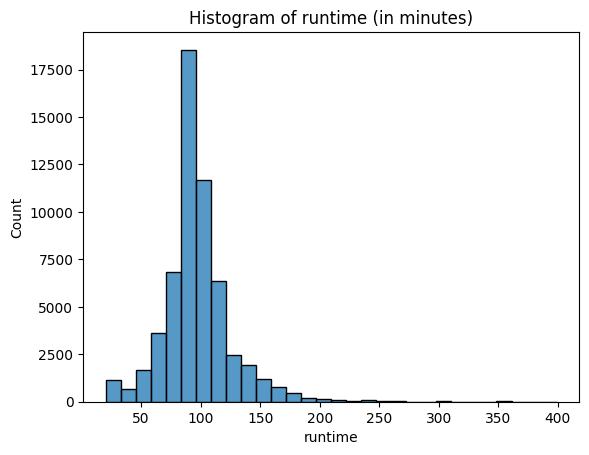

In [31]:
num_movies_gt_400 = len(movies_imdb[movies_imdb['runtime'] > 400])
num_movies_neg_runtime = len(movies_imdb[movies_imdb['runtime'] < 0])
num_movies_0_20_runtime = len(movies_imdb[(movies_imdb['runtime'] >= 0) & (movies_imdb['runtime'] <= 20)])

print(f"Number of movies with runtime > 400: {num_movies_gt_400}")
print(f"Number of movies with negative runtime: {num_movies_neg_runtime}")
print(f"Number of movies with runtime between [0, 20]: {num_movies_0_20_runtime}")

print(f"Number of na values: {movies_imdb['runtime'].isna().sum()}")

# Drop movies with runtime > 400, negative runtime and runtime between [0, 20] 
# (should we drop them or just set them to nan?)
movies_imdb = movies_imdb.drop(movies_imdb[movies_imdb['runtime'] > 400].index)
movies_imdb = movies_imdb.drop(movies_imdb[movies_imdb['runtime'] < 0].index)
movies_imdb = movies_imdb.drop(movies_imdb[(movies_imdb['runtime'] >= 0) & (movies_imdb['runtime'] <= 20)].index)

# Histogram of runtime
sns.histplot(data=movies_imdb, x="runtime", bins=30)
plt.title("Histogram of runtime (in minutes)")
plt.show()

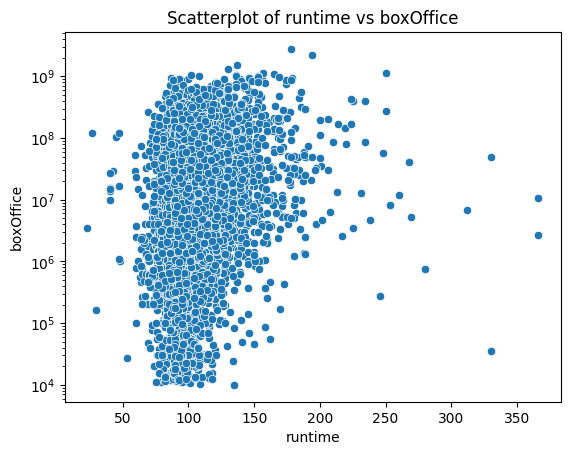

In [38]:
# Scatterplot of runtime vs boxOffice
sns.scatterplot(data=movies_imdb, x="runtime", y="boxOffice")
plt.title("Scatterplot of runtime vs boxOffice")
plt.yscale("log")
plt.show()

Number of movies with box office set to NaN: 70072
Proportion of movies with box office set to NaN: 0.8930692564553542


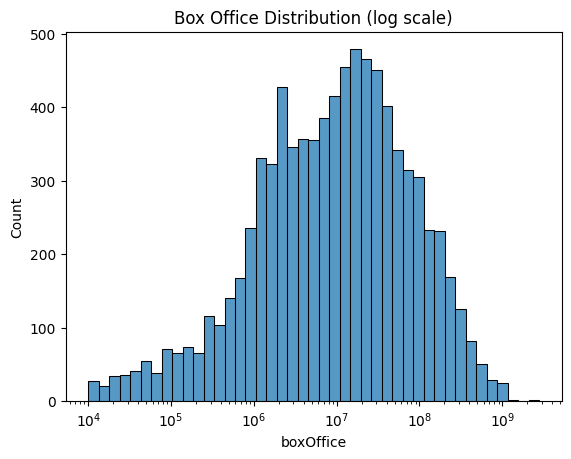

In [33]:
print(f"Number of movies with box office set to NaN: {movies_imdb['boxOffice'].isna().sum()}")
print(f"Proportion of movies with box office set to NaN: {movies_imdb['boxOffice'].isna().sum() / len(movies_imdb)}")

sns.histplot(data=movies_imdb, x="boxOffice", log_scale=True)
plt.title("Box Office Distribution (log scale)")
plt.show()

In [34]:
print(f"Number of movies with genresImdb information: {movies_imdb['genresImdb'].notnull().sum()}")
print(
    f"Proportion of movies with genresImdb information: {movies_imdb['genresImdb'].notnull().sum() / len(movies_imdb)}")

print(f"Number of movies with genresCmu information: {movies_imdb['genresCmu'].notnull().sum()}")
print(f"Proportion of movies with genresCmu information: {movies_imdb['genresCmu'].notnull().sum() / len(movies_imdb)}")

# Je pense pas que ca soit normal

Number of movies with genresImdb information: 28660
Proportion of movies with genresImdb information: 0.3652723611429737
Number of movies with genresCmu information: 76179
Proportion of movies with genresCmu information: 0.9709031123346333


In [512]:
movies_imdb_exploded = movies_imdb.explode('genresImdb')
imdb_genre_boxoffice = movies_imdb_exploded.dropna(subset=['genresImdb']).groupby('genresImdb')['boxOffice'].agg(
    ['mean', 'median'])
imdb_genre_boxoffice.columns = ['mean_boxoffice', 'median_boxoffice']

genre_counts = movies_imdb_exploded['genresImdb'].value_counts()
imdb_genre_boxoffice = imdb_genre_boxoffice.merge(genre_counts, left_index=True, right_index=True)
imdb_genre_boxoffice.columns = ['mean_boxoffice', 'median_boxoffice', 'num_movies']
print(imdb_genre_boxoffice)

             mean_boxoffice  median_boxoffice  num_movies
genresImdb                                               
Action         8.565336e+07        27007143.0        3190
Adult          5.000000e+07        50000000.0          65
Adventure      1.090502e+08        28445927.0        2428
Animation      1.480309e+08        55293297.5         612
Biography      2.883393e+07         6659377.0         960
Comedy         4.396099e+07        12000000.0        8611
Crime          3.659286e+07        11567217.0        3651
Documentary    1.604474e+07         1332110.0        1712
Drama          3.156991e+07         6600310.5       15160
Family         6.356189e+07        24371281.0        1332
Fantasy        5.979984e+07        17037887.0        1034
Film-Noir      1.680860e+06         1400000.0         419
Game-Show               NaN               NaN           1
History        2.365401e+07         5200493.0         801
Horror         3.137416e+07        11665465.0        1835
Music         

In [513]:
genre_counts.index

Index(['Drama', 'Comedy', 'Romance', 'Crime', 'Action', 'Adventure',
       'Thriller', 'Horror', 'Documentary', 'Mystery', 'Short', 'Family',
       'Musical', 'Western', 'Fantasy', 'Biography', 'War', 'Sci-Fi', 'Music',
       '\N', 'History', 'Animation', 'Sport', 'Film-Noir', 'Adult', 'News',
       'Reality-TV', 'Talk-Show', 'Game-Show'],
      dtype='object', name='genresImdb')

In [36]:
movies_imdb_exploded = movies_imdb.explode('genresCmu')
cmu_genre_boxoffice = movies_imdb_exploded.dropna(subset=['genresCmu']).groupby('genresCmu')['boxOffice'].agg(
    ['mean', 'median'])
cmu_genre_boxoffice.columns = ['mean_boxoffice', 'median_boxoffice']

genre_counts = movies_imdb_exploded['genresCmu'].value_counts()
cmu_genre_boxoffice = cmu_genre_boxoffice.merge(genre_counts, left_index=True, right_index=True)
cmu_genre_boxoffice.columns = ['mean_boxoffice', 'median_boxoffice', 'num_movies']
print(cmu_genre_boxoffice)

                  mean_boxoffice  median_boxoffice  num_movies
genresCmu                                                     
Absurdism           7.571945e+07        29106786.0          91
Acid western        6.412655e+05          641265.5           9
Action              8.875071e+07        23510601.0        8738
Action Comedy       8.380756e+07        38576276.5         168
Action Thrillers    1.093814e+08        44350926.0         516
...                          ...               ...         ...
World History       2.796540e+05          311542.0          19
World cinema        1.867080e+07         6204504.0        7141
Wuxia               8.764117e+07        96431972.5         125
Z movie                      NaN               NaN           3
Zombie Film         4.620866e+07        14210186.0         270

[363 rows x 3 columns]


# Methodologie

1. Prendre genre et creer un long str
2. couper aux delimiter qui sont pas des lettres et avoir une liste de touts les mots
3. unique tous les mots et en miniscules
4. voir comment les mots romantic et romance par exemple peut-être vus comme equivalent 


1.

In [527]:
genres = movies_imdb.dropna(subset="genresCmu").explode(column="genresCmu").genresCmu.values
genres_str = " ".join(str(g) for g in genres)

2.

In [528]:
split_characters = set()
for m in genres_str:
    for l in m:
        if not l.isalpha():
            split_characters.add(l)
            
split_characters

{' ', '&', "'", '-', '/', '5', '9', '[', ']'}

In [529]:
string = genres_str
for delimiter in split_characters:
    string = " ".join(string.split(delimiter))
    
words = string.split(" ")

3.

In [530]:
import nltk
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

words = list(map(lambda x: x.lower(), words)) #tout en minuscule
words = list(map(lambda x:lemmatizer.lemmatize(x), words)) #enlever les s
ags = nltk.pos_tag(words) # dire si c'est un verbe adjectif etc
words_, tags= np.array(list(map(list, zip(*ags))))

In [531]:
mask = (tags == np.array(["NN","NNS","NNP","NNPS","JJ"]).reshape(-1,1)).any(axis=0) # grader que les nouns et les adjs
words_len = np.array(list(map(lambda x : len(x),words_))) #taille des mots
mask = mask & (words_len>2) # garder que les mots de plus de 2 lettres 

In [532]:
counts = pd.Series(words_[mask]).value_counts() # compter combien de fois chaque mot apparait
pd.Series(counts[counts>1000]).index # les mots qui apparaissent plus de 1000 fois

Index(['drama', 'film', 'comedy', 'action', 'thriller', 'fiction', 'romance',
       'adventure', 'crime', 'black', 'white', 'cinema', 'world', 'movie',
       'family', 'romantic', 'indie', 'horror', 'documentary', 'short',
       'musical', 'silent', 'fantasy', 'mystery', 'animation', 'science',
       'war', 'western', 'japanese', 'period', 'child', 'political',
       'adaptation', 'chinese', 'art', 'biography', 'piece', 'psychological',
       'sport', 'biographical', 'bollywood', 'music', 'television',
       'historical'],
      dtype='object')